In [1]:
import numpy as np

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:

? np.nonzero()

In [47]:
%%writefile re

import numpy as np
import matplotlib.pyplot

def RT60(rir,fs,is_plot=False):
    """estimate reverberation time based on room impulse response time
        Args:
            rir: room impulse response
            fs: sample frequency
            
        Returns:
            estimated RT60 in second
    """
    rir = np.reshape(rir,newshape=[-1,1])
    rir_duration = np.float32(rir.shape[0])/fs
        
    start_pos =0
    end_pos = rir.shape[0]
    # 
    iidc = np.flipud(np.cumsum(np.flipud(rir**2)))# inverse integration decay curve, whole rir
    iidc_norm = 10*np.log10(iidc/np.max(iidc))

    # linear regression
    # further limit the time range
#     print np.nonzero(iidc_norm[start_pos:end_pos]<-5)
    db5_pos = np.nonzero(iidc_norm[start_pos:end_pos]<=-5)[0][0]+start_pos
    db35_pos = np.nonzero(iidc_norm[start_pos:end_pos]<-35)[0][0]+start_pos
    coeffs = np.polyfit(np.arange(db5_pos,db35_pos,dtype=np.float32)/fs,
                        iidc_norm[db5_pos:db35_pos],
                        deg=1)
    slope = coeffs[0]
    RT = -60.0/slope
    
    if is_plot:
        plt.figure()
        axs = plt.subplot()
        time = np.arange(0,rir_duration,1./fs)
        plt.plot(time,iidc_norm,label='inverse integration')
        plt.plot(time,time*slope+coeffs[1],label='line regression')
        plt.setp(axs.lines,linewidth=3)
        plt.title('RT30=%.2f'%RT)
        plt.xlabel('time(s)'); plt.ylabel('amplitude(dB)')
    return RT
    

In [8]:
import h5py

In [22]:
RIR_list = []
RIR_dir = '../Dereverberation/spec_mapping/RIR-Generator/RIRs_v2_no_delay/'
for set_name in ['Train','Develop','Test']:
    for RT_i, RT in enumerate([0.3,0.6,0.9]):
        for pos_i in xrange(2):
            RIR_file = h5py.File('%s/%s_%02d_%d.mat'%(RIR_dir,set_name,10*RT,pos_i+1))
            RIR = np.squeeze(np.asarray(RIR_file['RIR_no_delay'],dtype=np.float32))
            break

1.3997573041816675

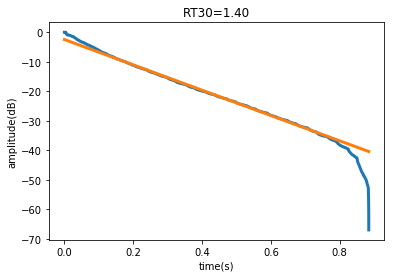

In [48]:
RT60(RIR,16000,True)